# Опыт Юнга

In [7]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from numpy.lib.twodim_base import mask_indices

class wave2d():
    def __init__(self, xNodes, yNodes, dx, dy, dt, speed):
        self.xNodes = xNodes
        self.yNodes = yNodes
        self.dx = dx
        self.dy = dy
        self.dt = dt
        self.speed = speed

        self.field = np.zeros(shape=(3, xNodes, yNodes), dtype="float64")
        self.obstacle = np.ones(shape=(xNodes,yNodes), dtype="float64")
        self.mask = self.obstacle.copy()
        self._boundary = None

        self.screen = None
        self.absoluteScreen = None
        self.screenXpos = None
        self.screenYpos = None
        self.screenAlignment = None

    
    def setBoundaryConditions(self, func):
        self._boundary = func


    def setObstacle(self, obstacle):
        if self.field[0,:,:].shape == obstacle.shape and obstacle.dtype == "float64":
            self.obstacle = obstacle.copy()
            self.mask[self.obstacle == 0] = np.nan


    def setScreenAt(self, size, xPosition, yPosition, alignment=0):
        self.screenXpos = int((self.xNodes - 1) * xPosition)
        self.screenYpos = int((self.yNodes - 1) * yPosition)
        self.screenAlignment = alignment

        if(alignment == 0):
            self.screen = np.zeros(shape=(int(self.yNodes*size)), dtype="float64")
            self.absoluteScreen = np.zeros(shape=(int(self.yNodes*size)), dtype="float64")
        elif(alignment == 1):
            self.screen = np.zeros(shape=(int(self.xNodes*size)), dtype="float64")
            self.absoluteScreen = np.zeros(shape=(int(self.xNodes*size)), dtype="float64")


    def getScreen(self):
        if self.screen is not None:
            if self.screenAlignment == 0:               
                screenStart = int(self.screenYpos - self.screen.size / 2)
                self.screen = self.field[2, self.screenXpos, screenStart:screenStart + self.screen.size]
            elif self.screenAlignment == 1:
                screenStart = int(self.screenXpos - self.screen.size / 2) 
                self.screen = self.field[2, screenStart:screenStart + self.screen.size, self.screenYpos]
            
            return self.screen.copy()

    def getAbsoluteScreen(self):
        if self.screen is not None:
            if self.screenAlignment == 0:               
                screenStart = int(self.screenYpos - self.screen.size / 2)
                self.absoluteScreen = np.maximum(self.absoluteScreen, np.absolute(self.field[2, self.screenXpos, screenStart:screenStart + self.screen.size]))  #Take the value of the maximum absolute value of the field encounter in the screens position
            elif self.screenAlignment == 1:
                screenStart = int(self.screenXpos - self.screen.size / 2)
                self.absoluteScreen = np.maximum(self.absoluteScreen, np.absolute(self.field[2, screenStart:screenStart + self.screen.size, self.screenYpos]))  #Take the value of the maximum absolute value of the field encounter in the screens position
            
            return self.absoluteScreen.copy()


    def getWave(self):
        wave = self.field[2,:,:].copy()

        if self.screen is not None:
            if self.screenAlignment == 0:
                screenStart = int(self.screenYpos - self.screen.size/2)
                wave[self.screenXpos, screenStart:(screenStart+self.screen.size)] = np.nan
            elif self.screenAlignment == 1:
                screenStart = int(self.screenXpos - self.screen.size/2)
                wave[screenStart:screenStart+(self.screen.size, self.screenYpos)] = np.nan
        
        wave *= self.mask
        return wave

    def update(self, *boundaryArgs):
        self.field[2, 1:-1, 1:-1] = (self.dt * self.speed / self.dx) ** 2 * (self.field[1, 2:, 1:-1] + self.field[1, :-2, 1:-1] - 2 * self.field[1, 1:-1, 1:-1]) +\
                                    (self.dt * self.speed / self.dy) ** 2 * (self.field[1, 1:-1, 2:] + self.field[1, 1:-1, :-2] - 2 * self.field[1, 1:-1, 1:-1]) +\
                                    2*self.field[1, 1:-1, 1:-1] - self.field[0, 1:-1, 1:-1]
        
        self.field[2,:,:] *= self.obstacle
        self._boundary(*boundaryArgs)
        self.field[0,:,:] = self.field[1,:,:]
        self.field[1,:,:] = self.field[2,:,:] 

In [8]:
import matplotlib as mtl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    

def setInitialConditions(wave, amplitude, frequency):
    wave.field[0,:,:] = 0
    wave.field[1,0,:] = amplitude * np.sin(2 * np.pi * frequency * wave.dt)


def setDoubleSlit(wave, xPosition, yPosition, separation, thickness, aperture):
    xNodes, yNodes = wave.field[0,:,:].shape
    slit = np.ones(shape=(xNodes, yNodes), dtype="float64")

    left, right = int(xNodes * (xPosition - thickness / 2)), int(xNodes * (xPosition + thickness / 2))
    upperY0, upperY1 = int(yNodes * (yPosition - separation / 2)), int(yNodes * (yPosition - separation / 2 - aperture))
    lowerY0, lowerY1 = int(yNodes * (yPosition + separation / 2)), int(yNodes * (yPosition + separation / 2 + aperture))

    slit[left:right, :upperY1] = 0
    slit[left:right, upperY0:lowerY0] = 0
    slit[left:right, lowerY1:] = 0

    wave.setObstacle(slit)


def boundary(step, duration, amplitude, frequency, wave):
    t = wave.dt * (step + 2)
    if duration <= 0:
        wave.field[2,0,:] = amplitude * np.sin(2 * np.pi * frequency * t)
    else:
        if t <= duration:
           wave.field[2,0,:] = amplitude * np.sin(2 * np.pi * frequency * t)
        else:
            wave.field[2,0,:] = 0.0

    wave.field[2,-1,:] = 0.0
    wave.field[2,:,0] = wave.field[2,:,1]
    wave.field[2,:,-1] = wave.field[2,:,-2]


def setPredictionOnScreen(axis, order, frequency, separation, aperture, screenDistance, speed, yMax, height):
    yMaxima = np.array([0, yMax])                
    xMaxima = np.array([height / 2, height / 2])

    graph, = axis.plot(xMaxima, yMaxima, "k--")
    for i in range(1, order + 1):
        fringe = maximaDistance(i, frequency, separation, aperture, screenDistance, speed)
        xMaxima = np.array([1, 1]) * (fringe + height / 2)
        axis.plot(xMaxima, yMaxima, "k--")

        xMaxima = np.array([1, 1])*(-fringe + height / 2)
        axis.plot(xMaxima, yMaxima, "k--")

    return graph


def maximaDistance(order, frequency, separation, aperture, screenDistance, speed):
    wavelenght = speed / frequency
    A = (separation + aperture) / 2
    a = (order ** 2 * wavelenght ** 2) / (4 * A ** 2) - 1
    b = (order * wavelenght - order ** 3 * wavelenght ** 3) / (4 * A ** 2)
    c = screenDistance ** 2 + (order ** 4 * wavelenght ** 4) / (16 * A ** 2) - (order ** 2 * wavelenght ** 2) / 2 + A ** 2

    R = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)

    fringe = order * wavelenght / (2 * A) * (R - order * wavelenght / 2)
    return fringe


def photogram(step, wave, screenGraph, fieldGraph, pulseDuration, pulseAmplitude, pulseFrequency, xScreen, T):
    time = wave.dt * (step + 1)
    wave.update(step, pulseDuration, pulseAmplitude, pulseFrequency, wave)
   
    screenData = wave.getAbsoluteScreen()
    fieldGraph.set_data(wave.getWave().T)
    screenGraph.set_data(xScreen, screenData)

    print(f"{time/T:0.2%}")

    return fieldGraph, screenGraph

0.05%
0.05%
0.05%
0.05%
0.10%
0.15%
0.20%
0.25%
0.30%
0.35%
0.40%
0.45%
0.50%
0.55%
0.60%
0.65%
0.70%
0.75%
0.80%
0.85%
0.90%
0.95%
1.00%
1.05%
1.10%
1.15%
1.20%
1.25%
1.30%
1.35%
1.40%
1.45%
1.50%
1.55%
1.60%
1.65%
1.70%
1.75%
1.80%
1.85%
1.90%
1.95%
2.00%
2.05%
2.10%
2.15%
2.20%
2.25%
2.30%
2.35%
2.40%
2.45%
2.50%
2.55%
2.60%
2.65%
2.70%
2.75%
2.80%
2.85%
2.90%
2.95%
3.00%
3.05%
3.10%
3.15%
3.20%
3.25%
3.30%
3.35%
3.40%
3.45%
3.50%
3.55%
3.60%
3.65%
3.70%
3.75%
3.80%
3.85%
3.90%
3.95%
4.00%
4.05%
4.10%
4.15%
4.20%
4.25%
4.30%
4.35%
4.40%
4.45%
4.50%
4.55%
4.60%
4.65%
4.70%
4.75%
4.80%
4.85%
4.90%
4.95%
5.00%
5.05%
5.10%
5.15%
5.20%
5.25%
5.30%
5.35%
5.40%
5.45%
5.50%
5.55%
5.60%
5.65%
5.70%
5.75%
5.80%
5.85%
5.90%
5.95%
6.00%
6.05%
6.10%
6.15%
6.20%
6.25%
6.30%
6.35%
6.40%
6.45%
6.50%
6.55%
6.60%
6.65%
6.70%
6.75%
6.80%
6.85%
6.90%
6.95%
7.00%
7.05%
7.10%
7.15%
7.20%
7.25%
7.30%
7.35%
7.40%
7.45%
7.50%
7.55%
7.60%
7.65%
7.70%
7.75%
7.80%
7.85%
7.90%
7.95%
8.00%
8.05%
8.10%
8.15%
8.20

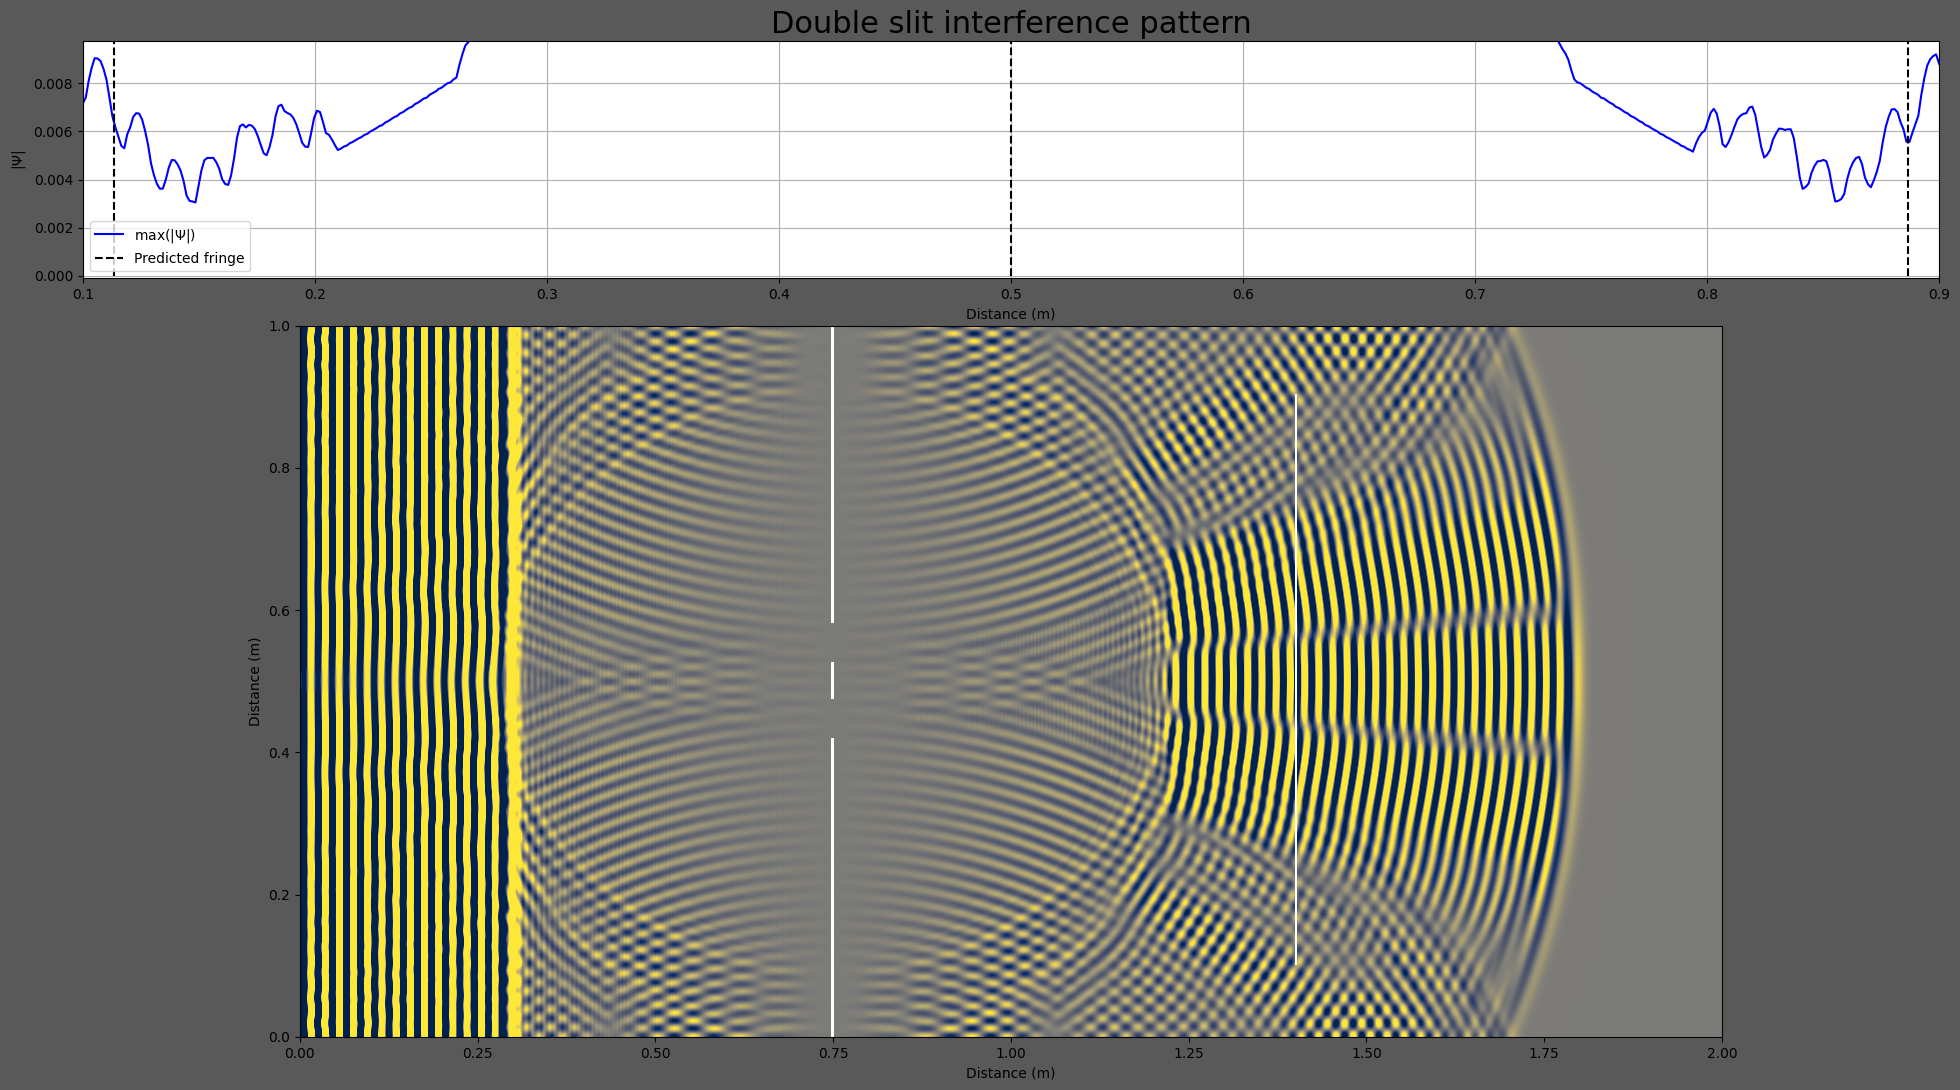

In [9]:
T = 2
width = 2
height = 1.0
dt = 0.001
speed = 0.9

pulseAmplitude = 0.05
pulseFrequency = 45.0
pulseDuration  = round(pulseFrequency * 0.5625 / speed) / pulseFrequency

slitXPosition  = 0.375
slitYPosition  = 0.5
slitSeparation = 0.05
slitThickness  = 0.001
slitAperture   = 0.056

colorCap = 0.195

screenXPosition = 0.7
screenYPosition = 0.5
screenSize      = 0.8

predictionOrder = 4

xNodes = int(width / (np.sqrt(2) * speed * dt)) - 1
yNodes = int(height / (np.sqrt(2) * speed * dt)) - 1
dx = width / xNodes
dy = height / yNodes

wave = wave2d(xNodes, yNodes, dx, dy, dt, speed)
wave.setScreenAt(screenSize, screenXPosition, screenYPosition)
wave.setBoundaryConditions(boundary)

setInitialConditions(wave, pulseAmplitude, pulseFrequency)
setDoubleSlit(wave, slitXPosition, slitYPosition, slitSeparation, slitThickness, slitAperture)

mtl.rcParams["toolbar"] = "None"
figure, (axis1, axis2)  = plt.subplots(2,1, gridspec_kw={"height_ratios": [1, 3]})
figure.set_size_inches(19.5555555, 11, forward=True)
axis1.grid()
xScreen = np.linspace(height * (screenYPosition-screenSize / 2), height * (screenYPosition + screenSize / 2), wave.screen.size)
yScreen = np.zeros(wave.screen.size)
screenGraph, = axis1.plot(xScreen, yScreen, "b-")

axis1.set_xlim(height*(screenYPosition - screenSize / 2), height * (screenYPosition + screenSize / 2))
axis1.set_title("Интерференция", fontsize=22)
axis1.set_xlabel("Расстояние (см)")
axis1.set_ylabel("Интенсивность (отн.ед.)")

predictionGraph = setPredictionOnScreen(axis1, predictionOrder, pulseFrequency, slitSeparation*height, slitAperture*height, (screenXPosition-slitXPosition)*width, speed, colorCap*pulseAmplitude, height)
plt.subplots_adjust(left=0.04, right=0.99, top=0.95, bottom=0.045, hspace=0.1)
figure.patch.set_facecolor("0.35")

fieldGraph = axis2.imshow(wave.getWave().T, extent=(0,width,0,height),cmap=plt.get_cmap("cividis"), aspect="equal", vmin=-colorCap*pulseAmplitude, vmax=colorCap*pulseAmplitude)
plt.show()